In [2]:
import cv2
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

data/examples/3-example.jpg


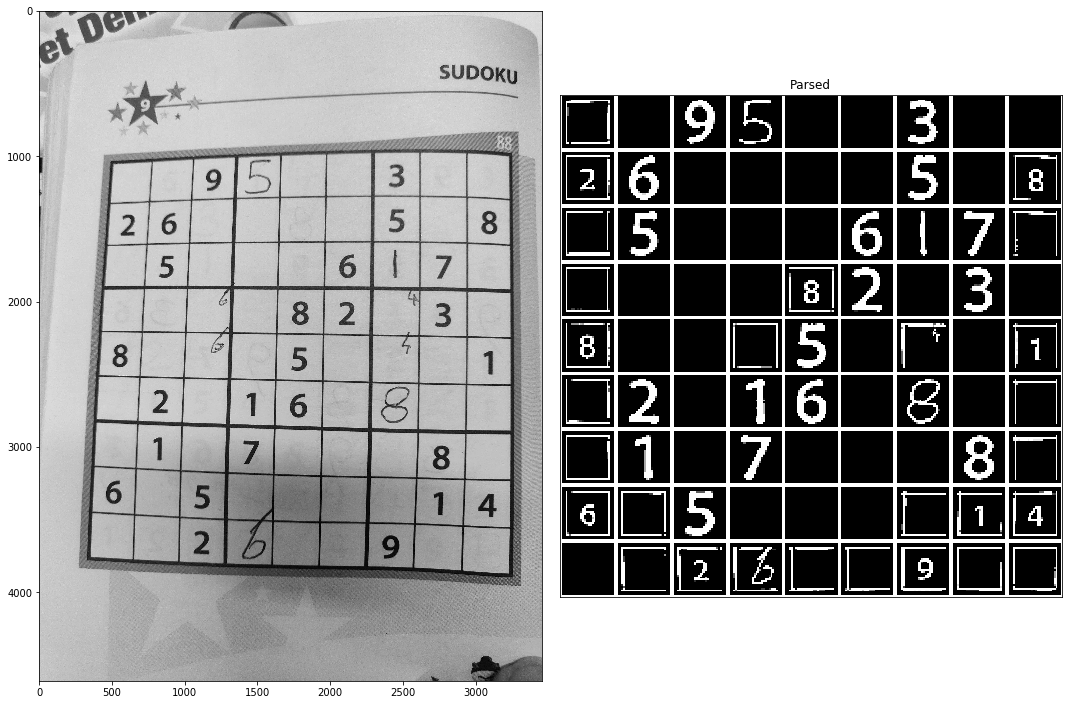

data/examples/IMG_4275.JPG


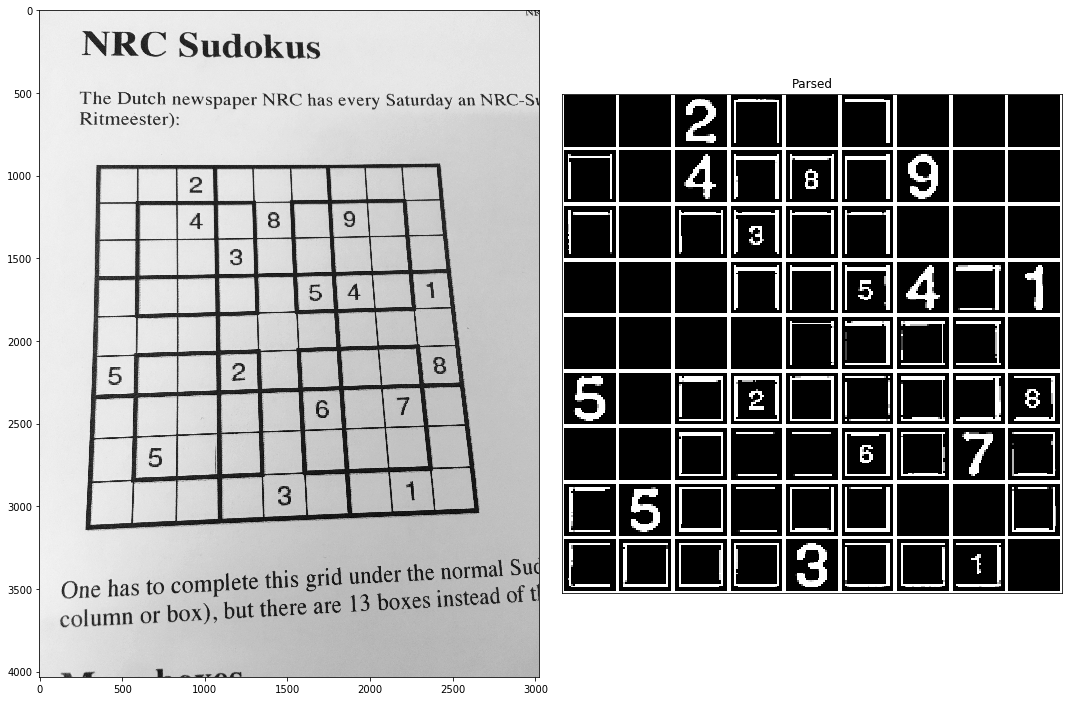

data/examples/1-example.jpeg


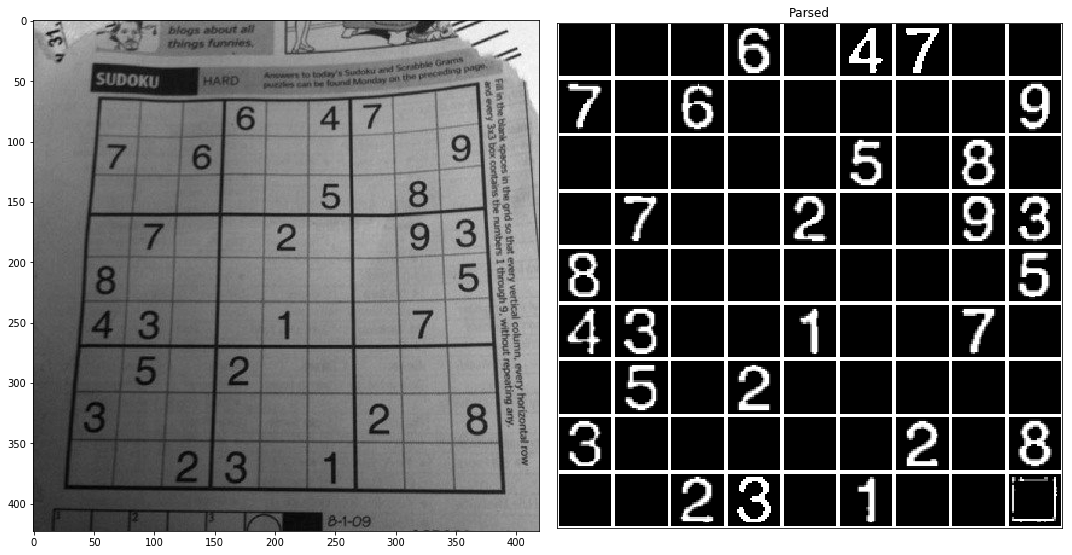

data/examples/2-example.png


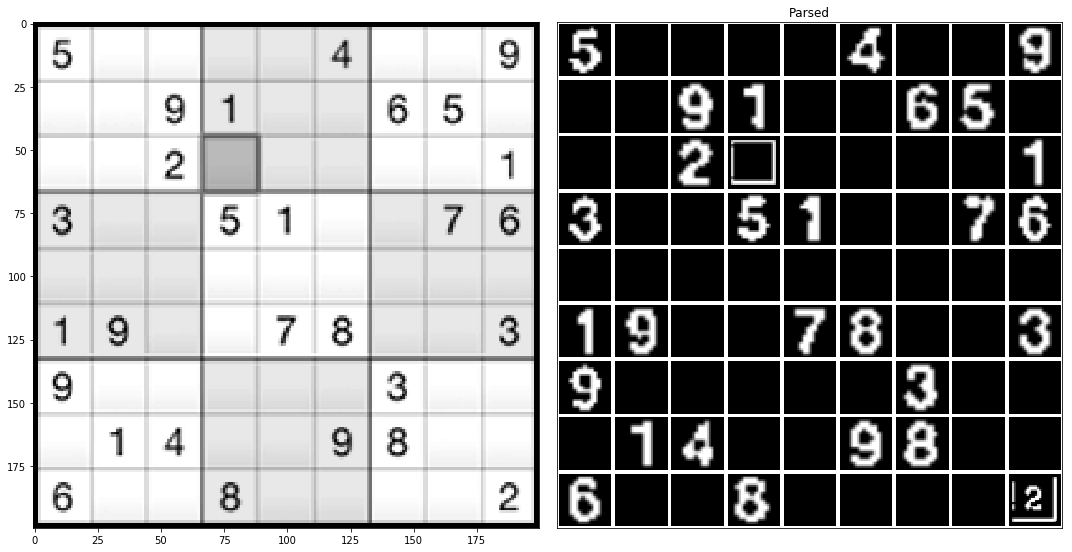

data/examples/4.jpg


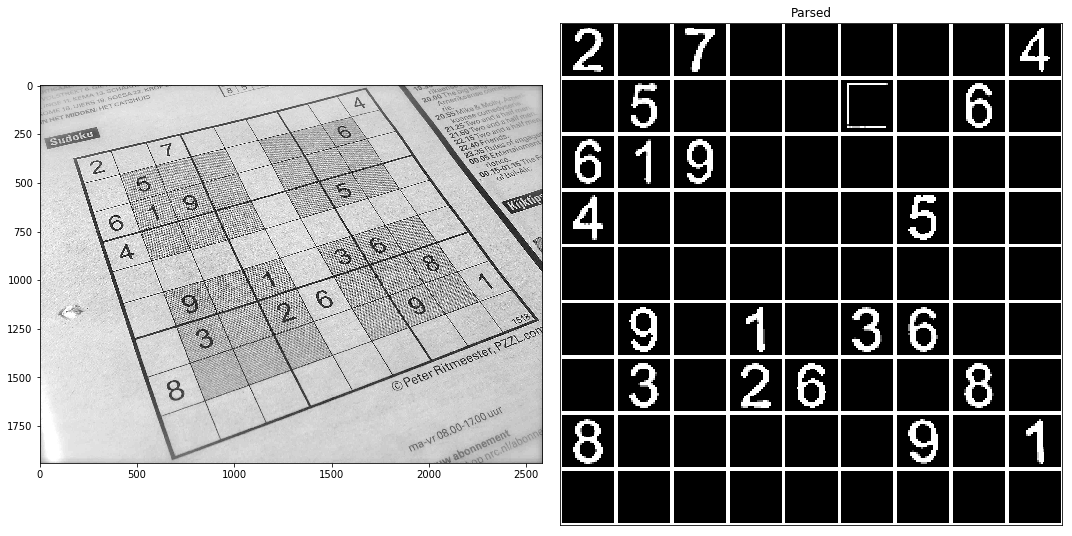

data/examples/5.jpg


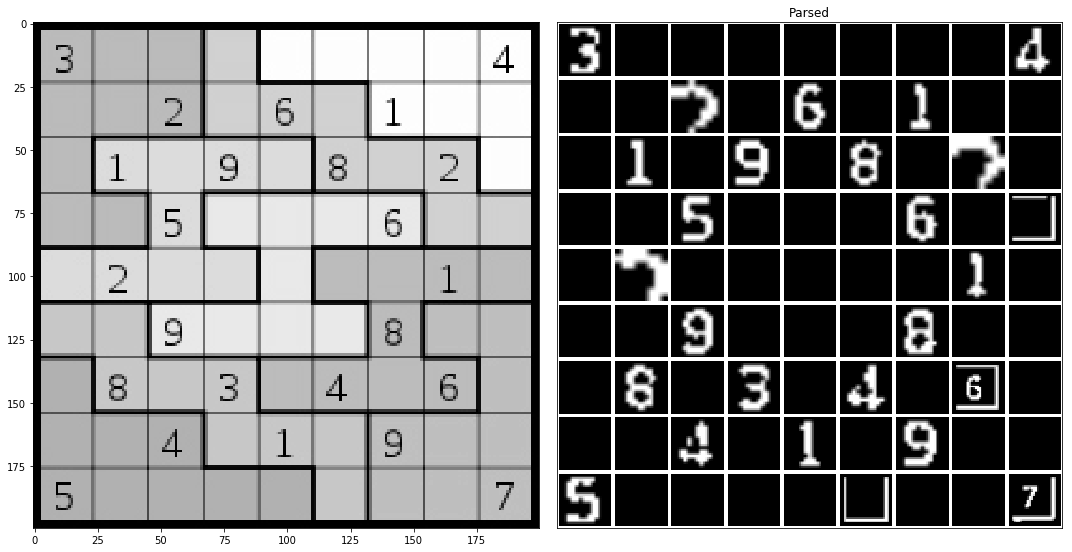

data/examples/6.png


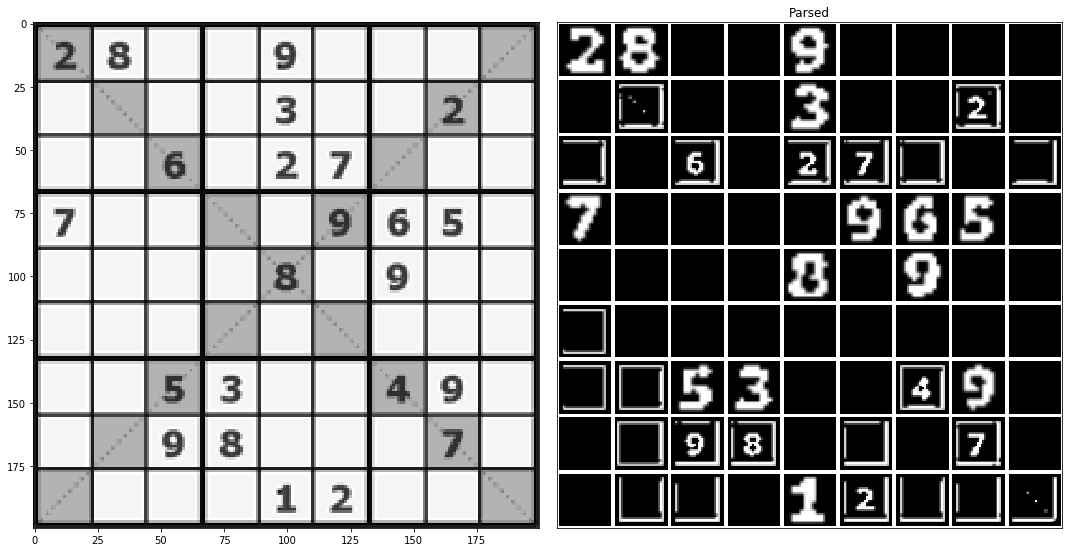

In [13]:
from sudoku.image_parser import (
    load_image, parse_grid
)
from sudoku.plotting import (
    image_from_digits, show_image, plot_many_images
)


def is_image(file: str) -> bool: 
    file = file.lower()
    return (
        file.endswith('.jpg') or 
        
        file.endswith('.jpeg') or 
        file.endswith('.png')
    )

directory = 'data/examples/'


def plot_example(path):
    img = load_image(path)
    digits = parse_grid(img)
    digit_img = image_from_digits(digits)
    plot_many_images([img, digit_img], ['Original', 'Parsed'])


def plot_many_images(images, titles):
    fig, axs = plt.subplots(1, len(images), figsize=(15, 10))
    for ax, img, title in zip(axs, images, titles):
        ax.imshow(img, interpolation="nearest", cmap="gray")
        plt.tight_layout()
        plt.title(title)
        plt.xticks([]), plt.yticks([])  # Hide tick marks
    plt.show()
    
    
for file in os.listdir(directory):
    if is_image(file):
        path = directory + file
        print(path)
        
        plot_example(path)

data/examples/3-example.jpg


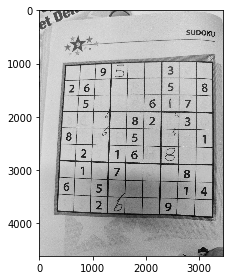

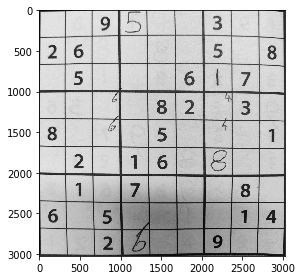

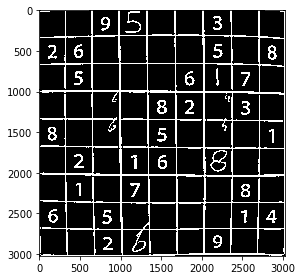

Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner
Patch rejected: near corner


ValueError: could not broadcast input array from shape (110,133) into shape (110,132)

In [38]:
from sudoku.image_parser import *
from sudoku.plotting import *

# Extensive loop  
for file in os.listdir(directory):
    file = '1-example.jpeg'
    if is_image(file):
        path = directory + file
        print(path)
        
        img = load_image(path)
        show_image(img)
        
        cropped = crop_to_grid(img)
        show_image(cropped)
        enhanced_digits = enhance_digits(cropped)
        show_image(enhanced_digits)
        
        squares = infer_grid(enhanced_digits)
        patches = extract_patches(enhanced_digits, squares)
        
        digits = [extract_digit(patch) for patch in patches]
        show_image(image_from_digits(digits))
        input()

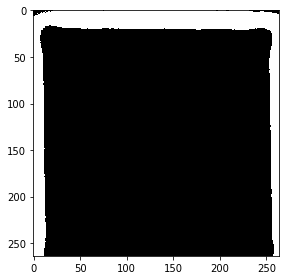

After lenght filter: 1
After center filter: 0
After corner filter: 0


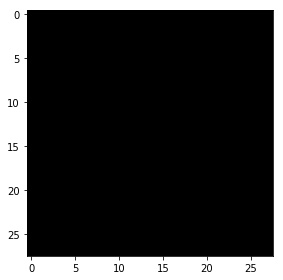

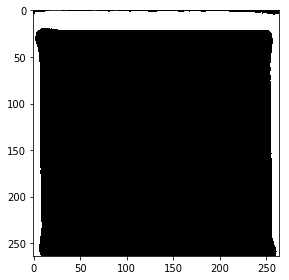

After lenght filter: 1
After center filter: 0
After corner filter: 0


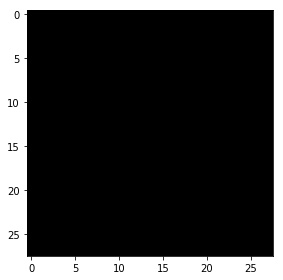

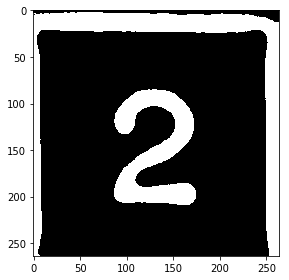

After lenght filter: 2
After center filter: 1
After corner filter: 1


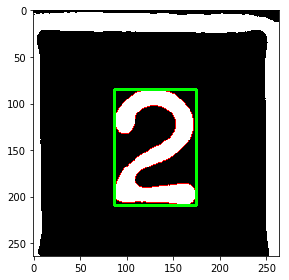

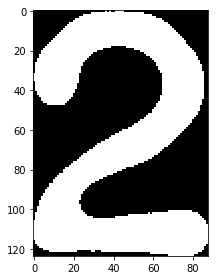

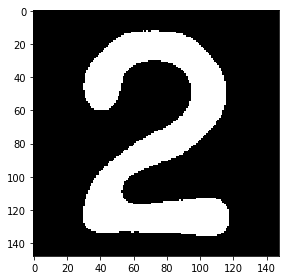

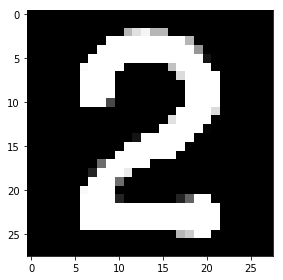

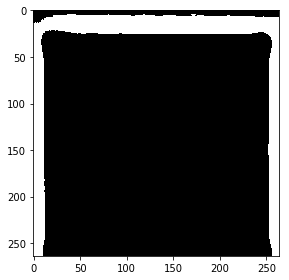

After lenght filter: 1
After center filter: 1
Patch rejected: near corner
After corner filter: 0


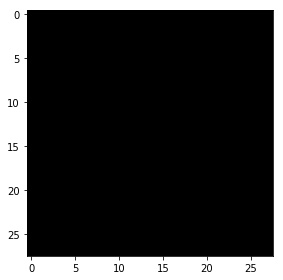

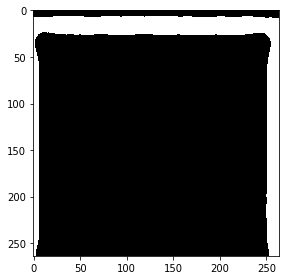

After lenght filter: 1
After center filter: 0
After corner filter: 0


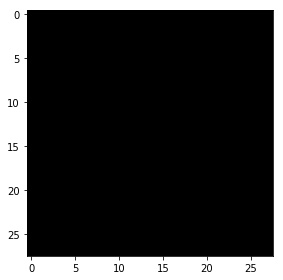

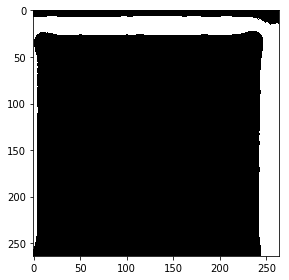

After lenght filter: 1
After center filter: 1
Patch rejected: near corner
After corner filter: 0


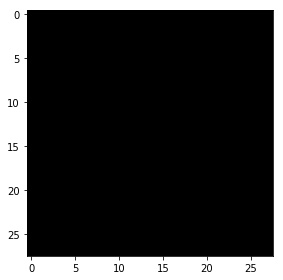

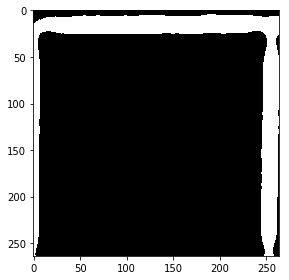

After lenght filter: 1
After center filter: 0
After corner filter: 0


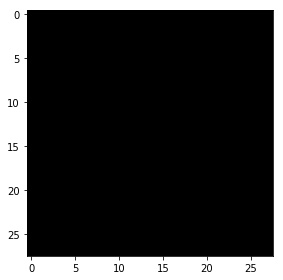

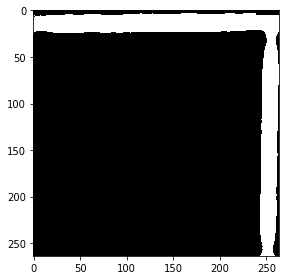

After lenght filter: 1
After center filter: 0
After corner filter: 0


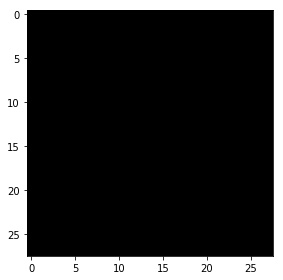

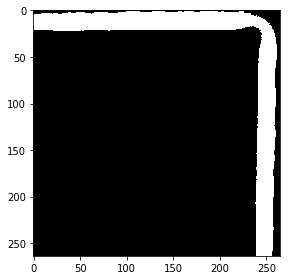

After lenght filter: 1
After center filter: 0
After corner filter: 0


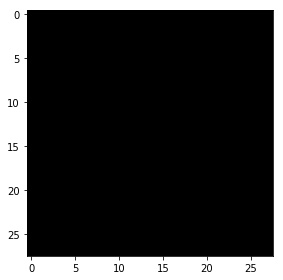

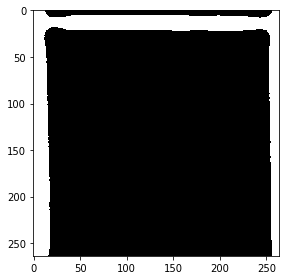

After lenght filter: 1
After center filter: 1
Patch rejected: near corner
After corner filter: 0


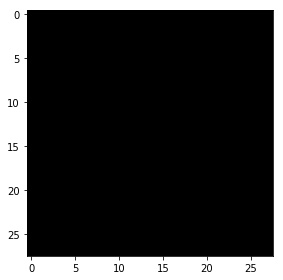

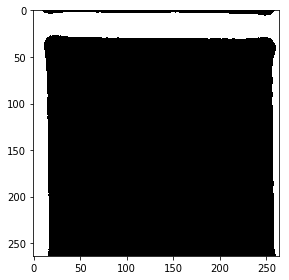

After lenght filter: 1
After center filter: 0
After corner filter: 0


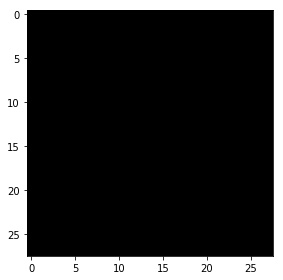

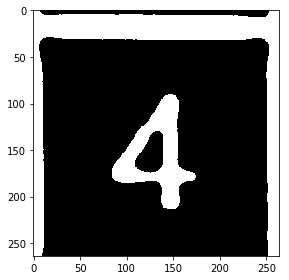

After lenght filter: 3
After center filter: 2
After corner filter: 2


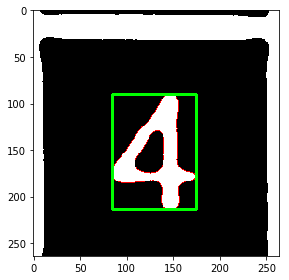

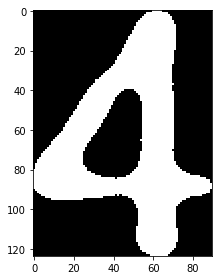

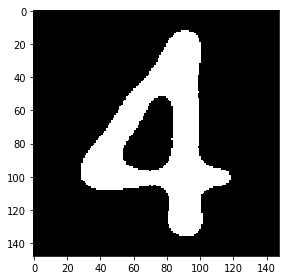

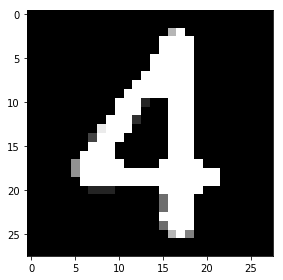

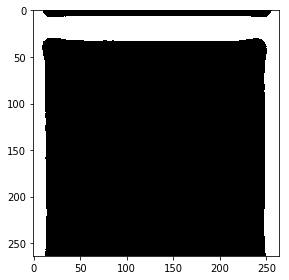

After lenght filter: 1
After center filter: 1
Patch rejected: near corner
After corner filter: 0


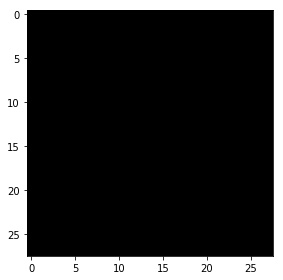

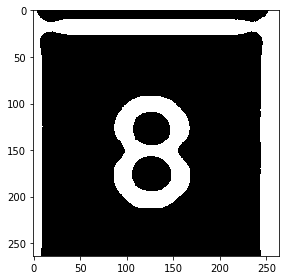

After lenght filter: 4
After center filter: 4
Patch rejected: near corner
After corner filter: 3


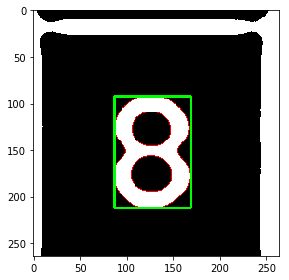

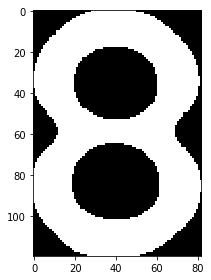

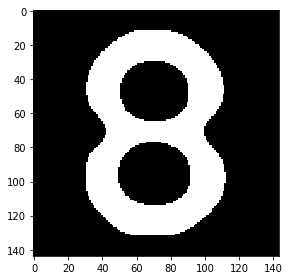

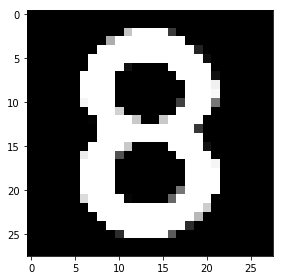

KeyboardInterrupt: 

In [37]:
from sudoku.image_parser import resize_digit

from sudoku.plotting import draw_contours


def in_center(width, height, cX, cY, fraction=0.4):
    margin_fraction = (1. - fraction) / 2

    width_margin = width * margin_fraction
    in_center_x = width_margin <= cX <= (width - width_margin)

    height_margin = height * margin_fraction
    in_center_y = height_margin <= cY <= (height - height_margin)

    return in_center_x and in_center_y


def filter_center_of_mass(width, height, contours):
    approved_contours = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] == 0:
            continue
            
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        
        if not in_center(width, height, cX, cY):
            continue

        approved_contours.append(c)
    return approved_contours


def filter_contour_length(contours):
    return [c for c in contours if len(c) > 4]
    

def pad_digit(digit, v_margin=0.1):
    height = digit.shape[0]
    width = digit.shape[1]

    v_margin = 0.1
    vertical_margin = int(height * v_margin)
    padded_height = height + 2 * vertical_margin

    horizontal_margin = int((padded_height - width) / 2)

    padded_digit = np.zeros((padded_height, padded_height))
    padded_digit[vertical_margin: vertical_margin + height, horizontal_margin: horizontal_margin + width] = digit.copy()
    
    return padded_digit



def filter_contours_near_corner(width, height, contours):

    accepted_contours = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        # show_image(image)

        rect = (
            (x, y),
            (x + w, y),
            (x, y + h),
            (x + w, y + h)
        )

        near_corner = False
        for point in rect:
            if not in_center(width, height, point[0], point[1], fraction=0.9):
                print("Patch rejected: near corner")
                near_corner = True
                break

        if not near_corner:
            accepted_contours.append(c)
    return accepted_contours
            

def extract_digit(patch):
    contours, _ = cv2.findContours(
        patch, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
    )
#     print("Nr. contours:", len(contours))

    width = patch.shape[1]
    height = patch.shape[0]

    contours = filter_contour_length(contours)
    print("After lenght filter:", len(contours))
    contours = filter_center_of_mass(width, height, contours)
    print("After center filter:", len(contours))
    contours = filter_contours_near_corner(width, height, contours)
    print("After corner filter:", len(contours))

    if len(contours) == 0:
        return np.zeros((28, 28))

    image = draw_contours(patch.copy(), contours)  

    x,y,w,h = cv2.boundingRect(np.concatenate(contours, axis=0))

    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
    show_image(image)

    rect = (
        (x, y),
        (x + w, y + h)
    )
    digit = cut_from_rectangle(patch.copy(), rect)
    show_image(digit)

    digit = pad_digit(digit)
    show_image(digit)

    digit = resize_digit(digit)
    return digit


for patch in patches:
    show_image(patch)
    
    digit = extract_digit(patch)
    show_image(digit)
    input()

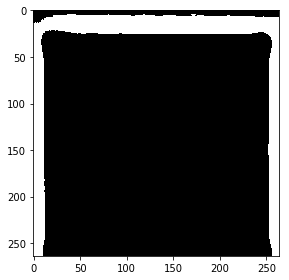

In [22]:
show_image(patch)

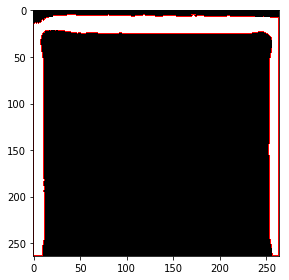

In [24]:
contours, _ = cv2.findContours(
    patch, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE
)
#     print("Nr. contours:", len(contours))

contours = filter_contour_length(contours)
contours = filter_center_of_mass(patch.shape[1], patch.shape[0], contours)

image = draw_contours(patch.copy(), contours)  
show_image(image)


In [25]:
len(contours)

1

In [ ]:

def filter_contours_near_corner(width, height, contours):

    accepted_contours = []
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
        # show_image(image)

        rect = (
            (x, y),
            (x + w, y),
            (x, y + h),
            (x + w, y + h)
        )

        near_corner = False
        for point in rect:
            if not in_center(width, height, point[0], point[1], fraction=0.9):
                print("Patch rejected: near corner")
                near_corner = True
                break

        if not near_corner:
            accepted_contours.append(c)

            return accepted_contours
            

width = patch.shape[1]
height = patch.shape[0]
accepted_contours = filter_contours_near_corner(width, height, contours)